In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
df = pd.read_csv('train.csv')
base_path = "./images_000"

In [3]:
df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [4]:
count = 0
for i in df['id']: 
    if i=="25c9dfc7ea69838d":
        print(count)
        print("landmark_id is :",df.landmark_id[count])
    else: count += 1

4
landmark_id is : 7


In [5]:
print(df.landmark_id[4])

7


In [6]:
df.shape

(1580470, 2)

In [7]:
samples = 2000
df = df.loc[df["id"].str.startswith(("000","001","002","003","004","005","006","007"), na=False), :]
num_classes = len(df['landmark_id'].unique())
num_data = len(df)

In [8]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

Size of training data: (3075, 2)
Number of unique classes: 2861


In [9]:
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))

   landmark_id  count
0       138982     15
1        83144      7
2       126637      5
3        36748      4
4       194914      4
5        29794      4
6        67929      3
7       107164      3
8        45428      3
9       186446      3
      landmark_id  count
2851        69767      1
2852        69813      1
2853        69832      1
2854        69997      1
2855        70050      1
2856        70088      1
2857        70134      1
2858        70173      1
2859        70265      1
2860       202972      1


Text(0.5, 1.0, 'Unique landmarks Distribution')

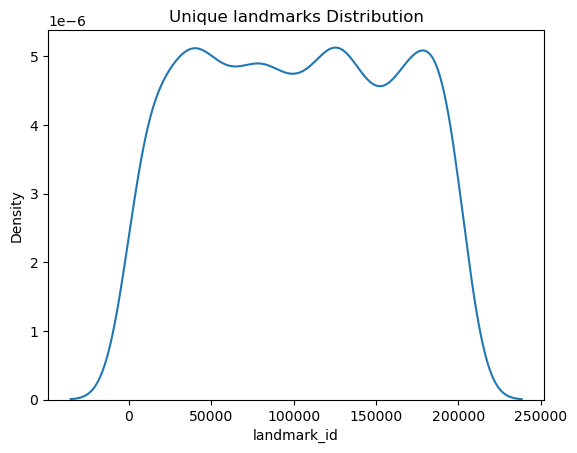

In [10]:
import seaborn as sns

sns.kdeplot(df['landmark_id'])
plt.title("Unique landmarks Distribution")

Amount of classes with less than or equal to five datapoints: 2859
Amount of classes between five and 10 datapoints: 2


Text(0, 0.5, 'Number of images')

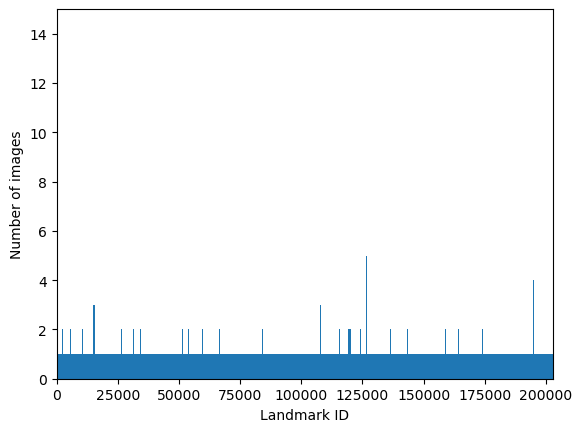

In [11]:
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
n = plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

4 sample images from random classes:


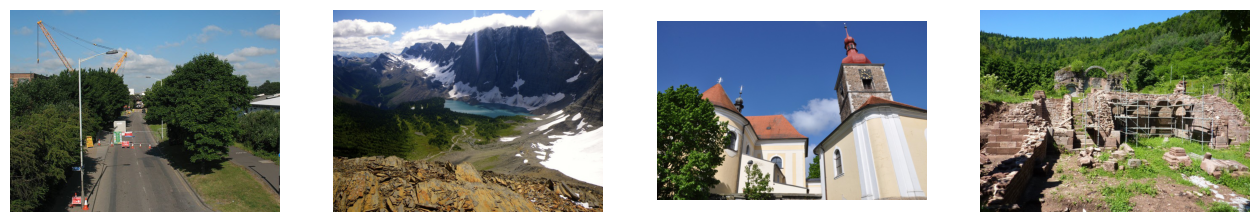

In [12]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [13]:
df.iloc[500,:]

id             002ab44b58207f4b
landmark_id               33992
Name: 266461, dtype: object

In [14]:
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
learning_rate   = 0.0001
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
#sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(learning_rate=learning_rate , momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 151,291,769 (577.13 MB)

 Trainable params: 151,291,763 (577.13 MB)

 Non-trainable params: 6 (24.00 B)

Model compiled!


In [15]:
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    #print((os.path.join(base_path,path)))
    assert img is not None, "file could not be read, check with os.path.exists()"
    #plt.imshow(np.array(im))
    return im, label

def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size

    if end_img > len(dataframe):
        end_img = len(dataframe)
        
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)
    
    return np.array(image_array), np.array(label_array)

In [16]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 2

# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")

Training on: 2460 samples
Validation on: 615 samples
Epoch:  1/2
Epoch:  2/2


In [17]:
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class: 1962 - Confidence: 0.0 - GT: 1334
Class: 1962 - Confidence: 0.0 - GT: 2718
Class: 1962 - Confidence: 0.0 - GT: 1619
Class: 1962 - Confidence: 0.0 - GT: 280
Class: 1962 - Confidence: 0.0 - GT: 719
Class: 1962 - Confidence: 0.0 - GT: 2548
Class: 1962 - Confidence: 0.0 - GT: 2379
Class: 1962 - Confidence: 0.0 - GT: 2404
Class: 1962 - Confidence: 0.0 - GT: 1664
Class: 1962 - Confidence: 0.0 - GT: 2645
Class: 1962 - Confidence: 0.0 - GT: 735
Class: 1962 - Confidence: 0.0 - GT: 2302
Class: 1962 - Confidence: 0.0 - GT: 1576
Class: 1962 - Confidence: 0.0 - GT: 1219
Class: 1962 - Confidence: 0.0 - GT: 2811
Class: 1962 - Confidence: 0.0 - GT: 1553
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
Class: 1962 - Confidence: 0.0 - GT: 589
Class: 1962 - Confidence: 0.0 - GT: 291
Class: 1962 - Confidence: 0.0 - GT: 659
Class: 1962 - Confidence: 0.0 - GT: 2741
Class: 1962 - Confidence: 0.0 - GT: 1304
Class: 1962 - Confidence: 0.0 - GT: 1276
Class: 1962 - Confidence: 0.0

In [19]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key= lambda x: x[2], reverse=True))

In [20]:
len(good_preds)

2

c:\Users\dipan\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


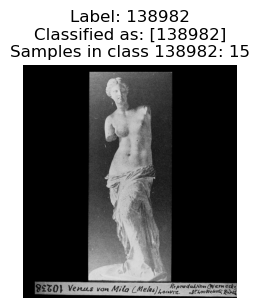

In [29]:
fig=plt.figure(figsize=(16, 16))
for i in range(1,2):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "\nClassified as: " + str(decode_label(lbl2)) + "\nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()